In [21]:
import os
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, StringType, DoubleType, BooleanType

In [22]:
spark = SparkSession.builder \
                .appName("flights") \
                .config("spark.executor.memory", "10G") \
                .config("spark.driver.memory", "2G") \
                .getOrCreate()

In [23]:
filepath = "./data/flights"
filenames = [ f"Combined_Flights_{y}.csv" for y in range(2018, 2023) ]

Schema para el dataset de vuelos

In [24]:
schema = StructType(
    [
        StructField("FlightDate", DateType(), True),
        StructField("Airline", StringType(), True),
        StructField("Origin", StringType(), True),
        StructField("Dest", StringType(), True),
        StructField("Cancelled", BooleanType(), True),
        StructField("Diverted", BooleanType(), True),
        StructField("CRSDepTime", IntegerType(), True),
        StructField("DepTime", DoubleType(), True),
        StructField("DepDelayMinutes", DoubleType(), True),
        StructField("DepDelay", DoubleType(), True),
        StructField("ArrTime", DoubleType(), True),
        StructField("ArrDelayMinutes", DoubleType(), True),
        StructField("AirTime", DoubleType(), True),
        StructField("CRSElapsedTime", DoubleType(), True),
        StructField("ActualElapsedTime", DoubleType(), True),
        StructField("Distance", DoubleType(), True),
        StructField("Year", IntegerType(), True),
        StructField("Quarter", IntegerType(), True),
        StructField("Month", IntegerType(), True),
        StructField("DayofMonth", IntegerType(), True),
        StructField("DayOfWeek", IntegerType(), True),
        StructField("Marketing_Airline_Network", StringType(), True),
        StructField("Operated_or_Branded_Code_Share_Partners", StringType(), True),
        StructField("DOT_ID_Marketing_Airline", StringType(), True),
        StructField("IATA_Code_Marketing_Airline", StringType(), True),
        StructField("Flight_Number_Marketing_Airline", StringType(), True),
        StructField("Operating_Airline", StringType(), True),
        StructField("DOT_ID_Operating_Airline", StringType(), True),
        StructField("IATA_Code_Operating_Airline", StringType(), True),
        StructField("Tail_Number", StringType(), True),
        StructField("Flight_Number_Operating_Airline", StringType(), True),
        StructField("OriginAirportID", StringType(), True),
        StructField("OriginAirportSeqID", StringType(), True),
        StructField("OriginCityMarketID", StringType(), True),
        StructField("OriginCityName", StringType(), True),
        StructField("OriginState", StringType(), True),
        StructField("OriginStateFips", StringType(), True),
        StructField("OriginStateName", StringType(), True),
        StructField("OriginWac", StringType(), True),
        StructField("DestAirportID", StringType(), True),
        StructField("DestAirportSeqID", StringType(), True),
        StructField("DestCityMarketID", StringType(), True),
        StructField("DestCityName", StringType(), True),
        StructField("DestState", StringType(), True),
        StructField("DestStateFips", StringType(), True),
        StructField("DestStateName", StringType(), True),
        StructField("DestWac", StringType(), True),
        StructField("DepDel15", StringType(), True),
        StructField("DepartureDelayGroups", StringType(), True),
        StructField("DepTimeBlk", StringType(), True),
        StructField("TaxiOut", DoubleType(), True),
        StructField("WheelsOff", DoubleType(), True),
        StructField("WheelsOn", DoubleType(), True),
        StructField("TaxiIn", DoubleType(), True),
        StructField("CRSArrTime", IntegerType(), True),
        StructField("ArrDelay", DoubleType(), True),
        StructField("ArrDel15", StringType(), True),
        StructField("ArrivalDelayGroups", StringType(), True),
        StructField("ArrTimeBlk", StringType(), True),
        StructField("DistanceGroup", StringType(), True),
        StructField("DivAirportLandings", StringType(), True),
    ]
)

# Caracterizacion de la poblacion variables numericas

In [25]:
df = spark.read.schema(schema).csv(f"{filepath}/{filenames[0]}", header=True)

In [26]:
df.show(10), df.count()

+----------+-----------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|          Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrD

(None, 5689512)

### Valores Tipicos

In [7]:
def calculate_stats(df):
    tendencias_list = df.describe([ el.name for el in df.schema if isinstance(el.dataType, (DoubleType, IntegerType)) and el.name not in ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek']]).collect()
    tendencias = {}
    for i in range(len(tendencias_list)):
        dict = tendencias_list[i].asDict()
        dict.pop('summary')
        tendencias[tendencias_list[i].summary] = dict
    return tendencias

# tendencias = calculate_stats(df)
# tendencias

### Quantiles

In [8]:
def calculate_quantiles(df):
    stats = {}
    for el in df.schema:
        if isinstance(el.dataType, (DoubleType, IntegerType))  and el.name not in ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek']:
            quantiles = df.approxQuantile(el.name, [0.25,0.5,0.75], 0)
            stats[el.name] = {"q25": quantiles[0], "q50": quantiles[1], "q75": quantiles[2] }
    return stats

# quantiles = calculate_quantiles(df)
# quantiles

In [9]:
def assign_quantiles(tendencias, quantiles):
    tendencias["q25"] = { item[0]:item[1]['q25'] for item in quantiles.items() }
    tendencias["q50"] = { item[0]:item[1]['q50'] for item in quantiles.items() }
    tendencias["q75"] = { item[0]:item[1]['q75'] for item in quantiles.items() }

# assign_quantiles(tendencias, quantiles)
# tendencias

### Valores Atipicos

In [10]:
def calculate_iqr_bounds(df, tendencias):
    factor = 1.5
    columns = [el.name for el in df.schema if isinstance(el.dataType, (DoubleType, IntegerType)) and el.name not in ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek']]
    outliers = {}
    for column in columns:
        q1 = tendencias['q25'][column]
        q3 = tendencias['q75'][column]
        irq = q3 - q1
        lower_bound = q1 - factor * irq
        upper_bound = q3 + factor * irq

        outliers[column] = {"lb":lower_bound, "up":upper_bound}

    return outliers

# outlier_bounds = calculate_iqr_bounds(df, tendencias)

In [11]:
def assign_iqr_bounds(tendencias, outlier_bounds):
    tendencias['lb'] = { item[0]:item[1]['lb'] for item in outlier_bounds.items() }
    tendencias['up'] = { item[0]:item[1]['up'] for item in outlier_bounds.items() }

# assign_iqr_bounds(tendencias, outlier_bounds)
# tendencias

## Tabla Resumen 2018

In [12]:
def write_table(tendencias, df, file):
    print("{:>20}".format("column"), end=" ", file=file)
    for head in tendencias.keys():
        print("{:>25}".format(head), end=" ", file=file)
    print(file=file)
    for col in [el.name for el in df.schema if isinstance(el.dataType, (DoubleType, IntegerType)) and el.name not in ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek']]:
        print("{:>20}".format(col), end=" ", file=file)
        for i, cell in enumerate([(tendencias[head][col]) for head in tendencias.keys()]):
            if isinstance(cell, (str, float)):
                print("{:>25.1f}".format(float(cell)), end=" ", file=file)
        print(file=file)

# write_table(tendencias, df, sys.stdout)

## Box Plot

In [13]:
def create_box_plot(df, filename, tendencias, show=False):
    fig, axs = plt.subplots(3, 1, figsize=(14,25))
    stat_list = []
    for col in [el.name for el in df.schema if isinstance(el.dataType, (DoubleType, IntegerType)) and el.name not in ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek']]:
        stat_dict = {}
        for i, item in enumerate([(head, tendencias[head][col]) for head in tendencias.keys()]):
            stat_dict["label"] = col
            stat_dict["fliers"] = []
            if item[0] == 'q25':
                stat_dict["q1"] = item[1]
            if item[0] == 'q50':
                stat_dict["med"] = item[1]
            if item[0] == 'q75':
                stat_dict["q3"] = item[1]
            if item[0] == 'lb':
                stat_dict["whislo"] = item[1]
            if item[0] == 'up':
                stat_dict["whishi"] = item[1]
            if item[0] == 'mean':
                stat_dict["mean"] = item[1]
        stat_list.append(stat_dict)
    prev = 0
    sorted_stat_list = sorted(stat_list, key=lambda x: x["med"])
    for i, k in enumerate(range(7,23,7)):
        axs[i].bxp(bxpstats=sorted_stat_list[prev:k])
        axs[i].tick_params(axis='x', labelrotation=35)
        prev = k

    name = os.path.basename(filename)[:-4]
    fig.suptitle(f"{name}", fontsize=18)
    fig.tight_layout(pad=2.7)
    if show:
        plt.show()
    else:
        fig.savefig(f"./images/{name}.png")
        plt.close()

# create_box_plot(df, filenames[0], tendencias)

# Calcular para 2018

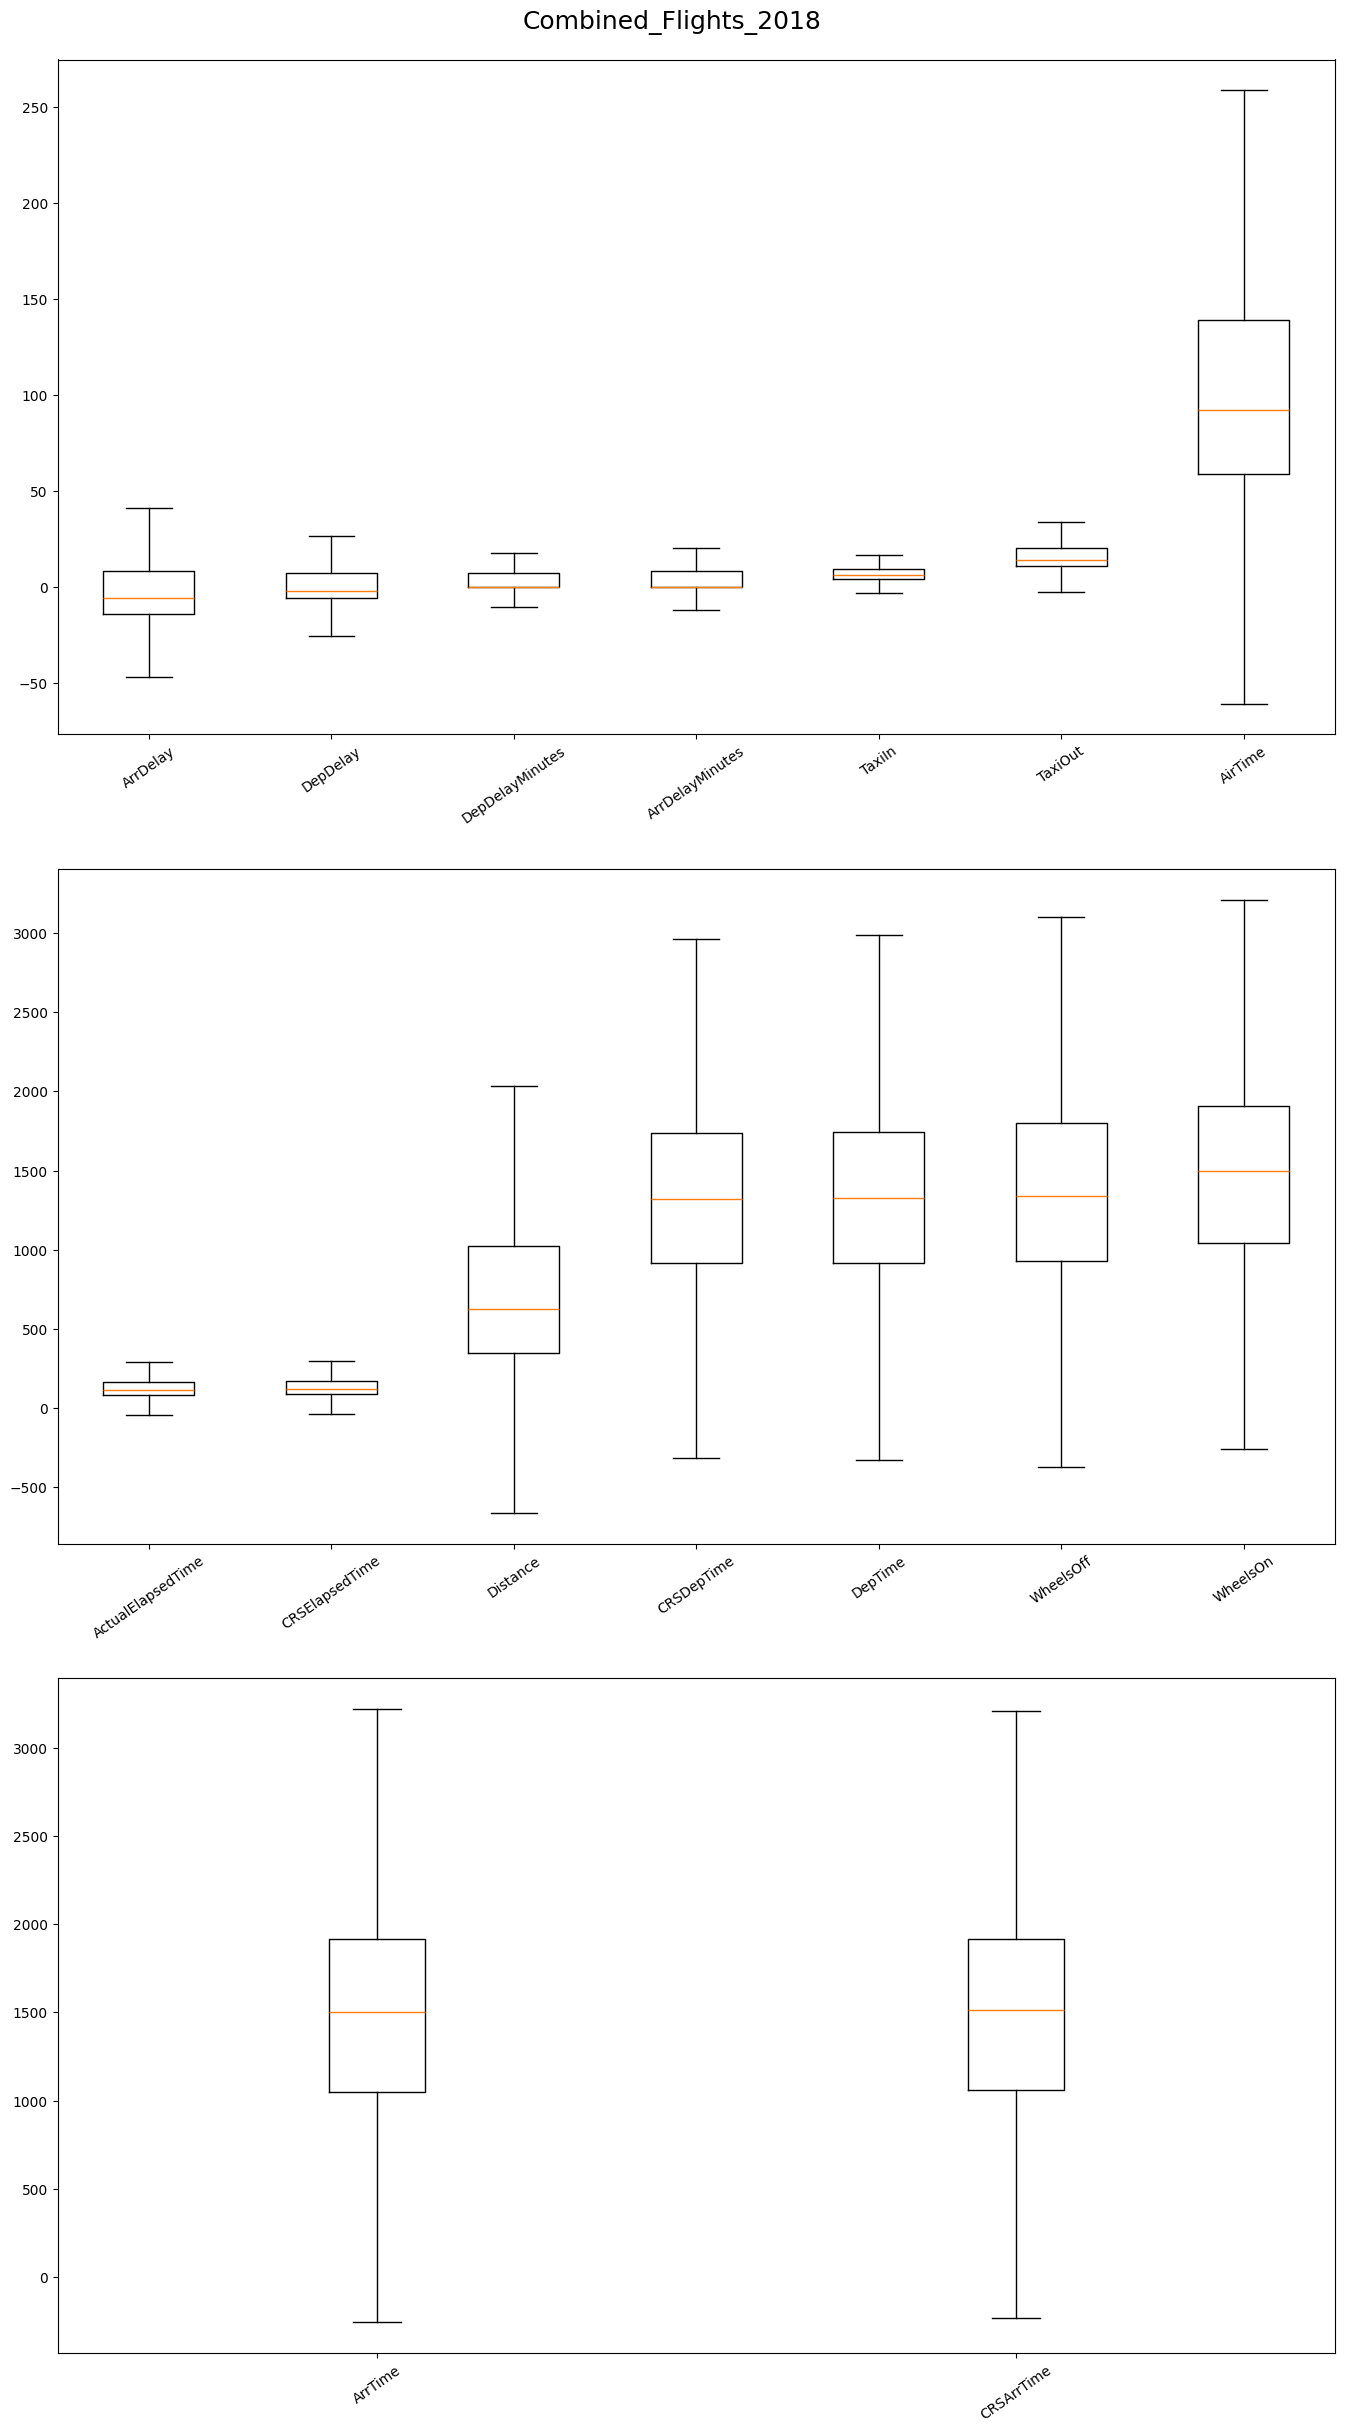

              column                     count                      mean                    stddev                       min                       max                       q25                       q50                       q75                        lb                        up 
          CRSDepTime                 5689512.0                    1330.3                     491.4                       1.0                    2359.0                     915.0                    1323.0                    1735.0                    -315.0                    2965.0 
             DepTime                 5604132.0                    1334.5                     504.9                       1.0                    2400.0                     916.0                    1327.0                    1745.0                    -327.5                    2988.5 
     DepDelayMinutes                 5602937.0                      13.5                      44.2                       0.0                    2625.0    

In [14]:
for filename in filenames[0:1]:
    df = spark.read.schema(schema).csv(f"{filepath}/{filename}", header=True)
    stats = calculate_stats(df)
    quantiles = calculate_quantiles(df)
    assign_quantiles(stats, quantiles)
    iqr_bounds = calculate_iqr_bounds(df, stats)
    assign_iqr_bounds(stats, iqr_bounds)
    create_box_plot(df, filename, stats, show=True)
    write_table(stats, df, sys.stdout)

Distribuciones para variables continuas

In [15]:
stats = pd.read_csv(f'images/{filenames[0][:-4]}.txt', sep='\s+')

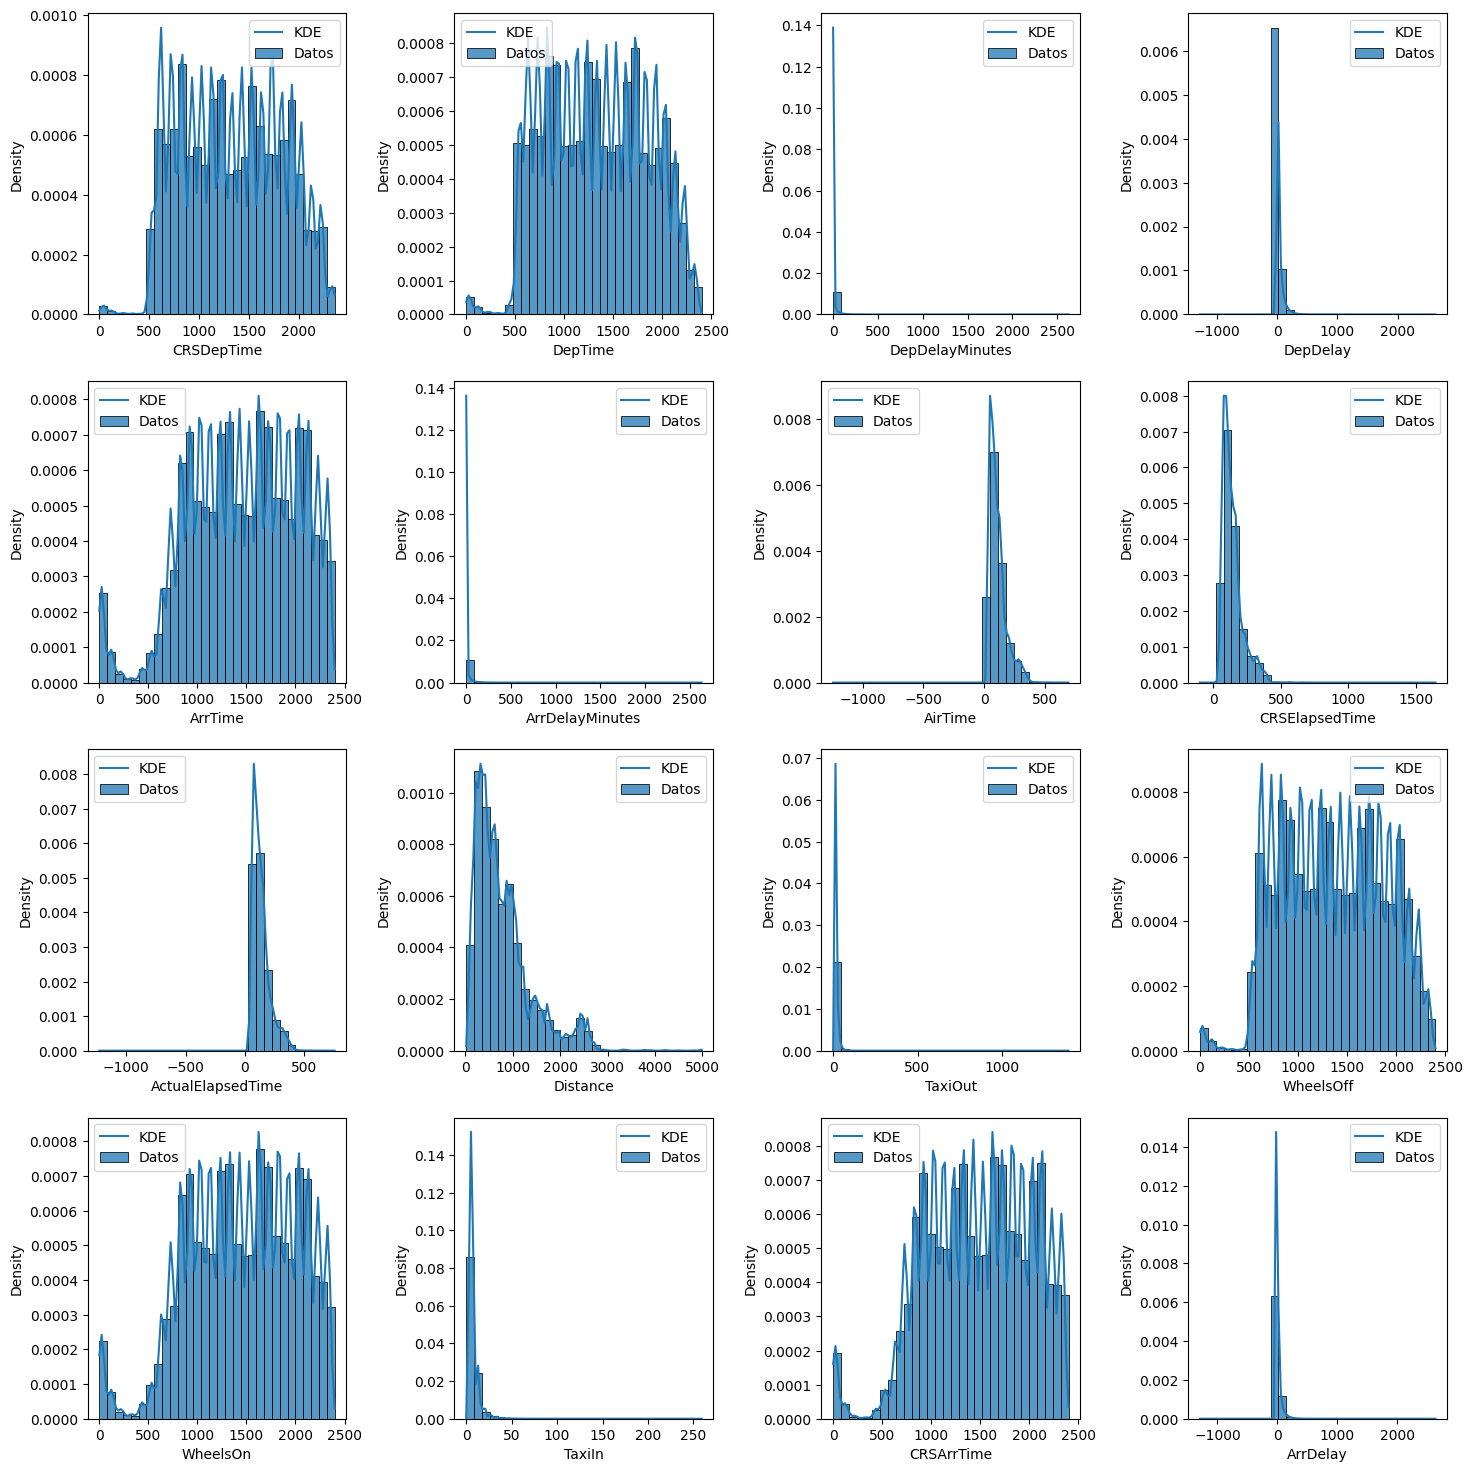

In [16]:
import math

n = len(stats)
r = math.ceil(math.sqrt(n))

fig, axs = plt.subplots(r,r, figsize=(15,15))
axs = axs.ravel()
kernels = {}
for i, row in stats.iterrows():
    col_df = df.select(row['column']).filter(F.col(row['column']).isNotNull())
    data = col_df.toPandas().to_numpy().reshape(-1)
    x = np.linspace(row['min'], row['max'], 100)
    kernel = gaussian_kde(data)
    kernels[row['column']] = kernel
    axs[i].plot(x, kernel(x), label='KDE')
    sns.histplot(data, stat='density', bins=30, kde=False, label='Datos', ax=axs[i])
    axs[i].legend()
    axs[i].set_xlabel(row['column'])
plt.tight_layout(pad=1.7)
plt.show()

# Caracterizacion de la poblacion variables categoricas

In [17]:
cat_columns = ['Marketing_Airline_Network', 'Operating_Airline', 'OriginAirportID', 'DestAirportID', 'OriginCityName', 'DestCityName', 'Diverted', 'DayOfWeek', 'Month', 'DistanceGroup']

In [18]:
for filename in filenames[0:1]:
    df = spark.read.schema(schema).csv(f"{filepath}/{filename}", header=True)
    for column in cat_columns:
        total = df.filter(F.col(column).isNotNull()).count()
        frecuencias = df.select(F.col(column)).filter(F.col(column).isNotNull()).groupBy(F.col(column)).agg(F.count("*").alias("frecuencia"))
        frecuencias_relativas = frecuencias.withColumn("frecuencia_relativa", F.round(F.col("frecuencia") / total, 4))
        frecuencias_relativas.repartition(1).write.mode("overwrite").format('parquet').save(f"./data/flights/{filename[:-4]}_{column}")
        frecuencias_relativas.show()
        print()
    time.sleep(1)

+-------------------------+----------+-------------------+
|Marketing_Airline_Network|frecuencia|frecuencia_relativa|
+-------------------------+----------+-------------------+
|                       UA|   1525263|             0.2681|
|                       NK|    176178|              0.031|
|                       B6|    305010|             0.0536|
|                       DL|    838465|             0.1474|
|                       F9|    120035|             0.0211|
|                       HA|     92810|             0.0163|
|                       G4|     96221|             0.0169|
|                       AS|    309195|             0.0543|
|                       VX|     17670|             0.0031|
|                       WN|   1352552|             0.2377|
|                       AA|    856113|             0.1505|
+-------------------------+----------+-------------------+




+-----------------+----------+-------------------+
|Operating_Airline|frecuencia|frecuencia_relativa|
+-----------------+----------+-------------------+
|               UA|    621565|             0.1092|
|               NK|    176178|              0.031|
|               EV|    167180|             0.0294|
|               B6|    305010|             0.0536|
|               DL|    461718|             0.0812|
|               9K|      1661|             3.0E-4|
|               OO|    531792|             0.0935|
|               F9|    120035|             0.0211|
|               YV|    153697|              0.027|
|               C5|     48010|             0.0084|
|               EM|      9087|             0.0016|
|               HA|     83723|             0.0147|
|               G4|     96221|             0.0169|
|               ZW|     98763|             0.0174|
|               CP|     44898|             0.0079|
|               YX|    203529|             0.0358|
|               AS|    184751| 

+---------------+----------+-------------------+
|OriginAirportID|frecuencia|frecuencia_relativa|
+---------------+----------+-------------------+
|          12888|       625|             1.0E-4|
|          12003|      2331|             4.0E-4|
|          15041|      1181|             2.0E-4|
|          12223|       898|             2.0E-4|
|          16133|         2|                0.0|
|          14986|      3897|             7.0E-4|
|          13851|     18991|             0.0033|
|          11150|       606|             1.0E-4|
|          15412|     11911|             0.0021|
|          10676|      1019|             2.0E-4|
|          11537|      1685|             3.0E-4|
|          13367|      4266|             7.0E-4|
|          13244|     16754|             0.0029|
|          13232|     84992|             0.0149|
|          11109|      9233|             0.0016|
|          10918|       310|             1.0E-4|
|          11865|       833|             1.0E-4|
|          12917|   

+-------------+----------+-------------------+
|DestAirportID|frecuencia|frecuencia_relativa|
+-------------+----------+-------------------+
|        12888|       624|             1.0E-4|
|        12003|      2332|             4.0E-4|
|        15041|      1183|             2.0E-4|
|        12223|       897|             2.0E-4|
|        16133|         2|                0.0|
|        14986|      3898|             7.0E-4|
|        13851|     18991|             0.0033|
|        15412|     11913|             0.0021|
|        11150|       606|             1.0E-4|
|        10676|      1018|             2.0E-4|
|        11537|      1685|             3.0E-4|
|        13367|      4267|             7.0E-4|
|        13244|     16756|             0.0029|
|        13232|     84982|             0.0149|
|        11109|      9230|             0.0016|
|        10918|       311|             1.0E-4|
|        11865|       833|             1.0E-4|
|        12917|      1079|             2.0E-4|
|        1240

+--------------------+----------+-------------------+
|      OriginCityName|frecuencia|frecuencia_relativa|
+--------------------+----------+-------------------+
|     Gainesville, FL|      2092|             4.0E-4|
|        Richmond, VA|     18967|             0.0033|
|         Ontario, CA|     18590|             0.0033|
|          Tucson, AZ|     13103|             0.0023|
|       Pago Pago, TT|       122|                0.0|
|    Myrtle Beach, SC|      8961|             0.0016|
|         Medford, OR|      6696|             0.0012|
|    Palm Springs, CA|      8041|             0.0014|
|         Redding, CA|      1169|             2.0E-4|
|       St. Cloud, MN|       145|                0.0|
|         Durango, CO|      2851|             5.0E-4|
|     Devils Lake, ND|       626|             1.0E-4|
|          Mobile, AL|      4027|             7.0E-4|
|  Corpus Christi, TX|      4291|             8.0E-4|
|        Columbus, GA|       606|             1.0E-4|
|      Huntsville, AL|      

+--------------------+----------+-------------------+
|        DestCityName|frecuencia|frecuencia_relativa|
+--------------------+----------+-------------------+
|     Gainesville, FL|      2091|             4.0E-4|
|        Richmond, VA|     18967|             0.0033|
|          Tucson, AZ|     13105|             0.0023|
|         Ontario, CA|     18589|             0.0033|
|       Pago Pago, TT|       122|                0.0|
|    Myrtle Beach, SC|      8962|             0.0016|
|         Medford, OR|      6699|             0.0012|
|    Palm Springs, CA|      8041|             0.0014|
|         Redding, CA|      1169|             2.0E-4|
|       St. Cloud, MN|       145|                0.0|
|         Durango, CO|      2851|             5.0E-4|
|     Devils Lake, ND|       627|             1.0E-4|
|          Mobile, AL|      4026|             7.0E-4|
|  Corpus Christi, TX|      4290|             8.0E-4|
|        Columbus, GA|       606|             1.0E-4|
|      Huntsville, AL|      

+--------+----------+-------------------+
|Diverted|frecuencia|frecuencia_relativa|
+--------+----------+-------------------+
|    true|     13955|             0.0025|
|   false|   5675557|             0.9975|
+--------+----------+-------------------+




+---------+----------+-------------------+
|DayOfWeek|frecuencia|frecuencia_relativa|
+---------+----------+-------------------+
|        1|    860802|             0.1513|
|        6|    701328|             0.1233|
|        3|    823966|             0.1448|
|        5|    842255|              0.148|
|        4|    836891|             0.1471|
|        7|    817134|             0.1436|
|        2|    807136|             0.1419|
+---------+----------+-------------------+




+-----+----------+-------------------+
|Month|frecuencia|frecuencia_relativa|
+-----+----------+-------------------+
|    1|    457688|             0.0804|
|   10|    670090|             0.1178|
|   11|    638985|             0.1123|
|   12|    649325|             0.1141|
|    2|    268105|             0.0471|
|    3|    346132|             0.0608|
|    4|    482983|             0.0849|
|    5|    350044|             0.0615|
|    6|    317713|             0.0558|
|    7|    367221|             0.0645|
|    8|    503612|             0.0885|
|    9|    637614|             0.1121|
+-----+----------+-------------------+




+-------------+----------+-------------------+
|DistanceGroup|frecuencia|frecuencia_relativa|
+-------------+----------+-------------------+
|            7|    237425|             0.0417|
|           11|    106566|             0.0187|
|            3|   1073331|             0.1887|
|            8|    115446|             0.0203|
|            5|    584264|             0.1027|
|            6|    232271|             0.0408|
|            9|     75415|             0.0133|
|            1|    799932|             0.1406|
|           10|    148669|             0.0261|
|            4|    869840|             0.1529|
|            2|   1446353|             0.2542|
+-------------+----------+-------------------+




In [19]:
spark.stop()